In [2]:
import pandas as pd

import numpy as np

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score 

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import time

from scipy.stats import exponweib

from scipy.optimize import fmin

from scipy.stats import gamma

from scipy.stats import norm

# Load data 



In [3]:
'''Store all the data into an array'''

Df=pd.DataFrame(list(),columns=['Day','Driver ID', 'Total Number of Shifts', 'Average Order Number',
           'Average Shift Duration (sec)', 'Average Occupied Time (sec)',
           'First Shift Start Time', 'Average Occupied Distance(m)',
           'Gap Between Shifts'])

date_list=list(range(1,15,1))

GetStr=lambda x:str(x) if x>=10 else '0'+str(x)

Get_hour=lambda x:int(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(x))[11:13])


for dt in date_list:
    
    print('*'*50)
    
    print("date: ", dt)

    df = pd.read_excel('./Data/Source/indexNov'+GetStr(dt)+'.xlsx')
    
    df['First Shift Start Time']=df.apply(lambda x:Get_hour(int(x['First Shift Start Time'])),axis=1)
    
    Array=np.array(df[['Index','Total Number of Shifts', 'Average Order Number',
           'Average Shift Duration (sec)', 'Average Occupied Time (sec)',
           'First Shift Start Time', 'Average Occupied Distance(m)',
           'Gap Between Shifts']])

    
    if dt==1:
        
        Features=Array
        
    else:
    
        Features=np.concatenate((Features,Array),axis=0)

Features = Features[Features[:,0].argsort()]

Cluster1=Features[np.argwhere(Features[:,0] ==1)[0][0]:np.argwhere(Features[:,0] ==2)[0][0],:]
Cluster2=Features[np.argwhere(Features[:,0] ==2)[0][0]:np.argwhere(Features[:,0] ==3)[0][0],:]
Cluster3=Features[np.argwhere(Features[:,0] ==3)[0][0]:,:]


**************************************************
date:  1
**************************************************
date:  2
**************************************************
date:  3
**************************************************
date:  4
**************************************************
date:  5
**************************************************
date:  6
**************************************************
date:  7
**************************************************
date:  8
**************************************************
date:  9
**************************************************
date:  10
**************************************************
date:  11
**************************************************
date:  12
**************************************************
date:  13
**************************************************
date:  14


# Generate data

In [4]:
'''Sampling'''

count1 = 13040;
count2 = 16832;
count3 = 3624;


'''Shifts quantity'''

def Random_pick(array,num):
    
    row_rand_array = np.arange(array.shape[0])

    np.random.shuffle(row_rand_array)
    
    return array[row_rand_array[0:num]]

shiftNum1=Random_pick(Cluster1[:,1],count1)

shiftNum2=Random_pick(Cluster2[:,1],count2)

shiftNum3=Random_pick(Cluster3[:,1],count3)







# Shift Duration

In [5]:
'''Shift Duration: Weibull Distribution'''

shiftDur1=Cluster1[:,3]/3600

shiftDur2=Cluster2[:,3]/3600

shiftDur3=Cluster3[:,3]/3600

def fitweibull(x):
    
    def optfun(theta):
        return -np.sum(np.log(exponweib.pdf(x, 1, theta[0], scale = theta[1], loc = 0)))
    logx = np.log(x)
    shape = 1.2 / np.std(logx)
    scale = np.exp(np.mean(logx) + (0.572 / shape))
    return fmin(optfun, [shape, scale], xtol = 0.01, ftol = 0.01, disp = 0)

wbl_loc1, wbl_scale1=fitweibull(shiftDur1)

wbl_loc2, wbl_scale2=fitweibull(shiftDur2)

wbl_loc3, wbl_scale3=fitweibull(shiftDur3)


def Generate_Dur(arr1,arr2,loc,scale,num):
    
    for i in range(num):
    
        s=np.random.weibull(loc)*scale

        while s<arr2.min() or s>arr2.max():

             s=np.random.weibull(loc)*scale
                
        arr1.append(s)
        
    return np.array(arr1)


Generated_shiftDur1=list()

Generated_shiftDur2=list()

Generated_shiftDur3=list()

    
Generated_shiftDur1=Generate_Dur(Generated_shiftDur1,shiftDur1,wbl_loc1,wbl_scale1,count1)

Generated_shiftDur2=Generate_Dur(Generated_shiftDur2,shiftDur2,wbl_loc2,wbl_scale2,count2)  

Generated_shiftDur3=Generate_Dur(Generated_shiftDur3,shiftDur3,wbl_loc3,wbl_scale3,count3)


print(wbl_loc1,wbl_scale1)

print(wbl_loc2,wbl_scale2)

print(wbl_loc3,wbl_scale3)



1.1448874196813645 1.3540927487593395
1.5272323333617028 1.5967962612590632
1.693025268198204 4.802695301769451


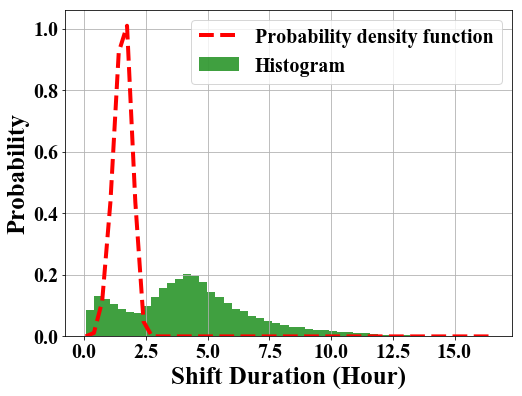

In [6]:


def weib(x,n,a):
    return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)


def ShiftDur_Plot(shiftDur,wbl_loc,wbl_scale):

    x = np.linspace(shiftDur.min(), shiftDur.max(), 50)

    figsize = 8,6

    font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

    font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}

    figure, ax1 = plt.subplots(figsize=figsize)

    labels = ax1.get_xticklabels() + ax1.get_yticklabels()

    [label.set_fontsize(20) for label in labels]

    [label.set_fontname('Times New Roman') for label in labels]

    ax1.plot(x,weib(x,wbl_loc,wbl_scale),'r--',linewidth=4,label='Probability density function')

    ax1.hist(shiftDur, 50,label='Histogram',facecolor='g', density=True, alpha=0.75)

    ax1.set_ylabel('Probability',font_label)

    ax1.set_xlabel('Shift Duration (Hour)',font_label)

    ax1.legend(loc = 'upper right',prop=font_legend)

    plt.grid()

    plt.show()

ShiftDur_Plot(shiftDur3,wbl_loc3,wbl_scale3)

# First Shift Start Time

In [7]:
'''Start Time: Gaussian'''

Starttime1=Cluster1[:,5]

Starttime2=Cluster2[:,5]

Starttime3=Cluster3[:,5]



def Generate_Start(arr1,arr2,mu,sigma,num):
    
    for i in range(num):
    
        s=np.random.normal(mu,sigma)

        while s<arr2.min() or s>arr2.max():

            s=np.random.normal(mu,sigma)
                
        arr1.append(s)
        
    return np.array(arr1)


Generated_Start1=list()

Generated_Start2=list()

Generated_Start3=list()


Gau_mean_1,Gau_std_1=Starttime1.mean(), Starttime1.std()

Gau_mean_2,Gau_std_2=Starttime2.mean(), Starttime2.std()

Gau_mean_3,Gau_std_3=Starttime3.mean(), Starttime3.std()


print(Gau_mean_1,Gau_std_1)

print(Gau_mean_2,Gau_std_2)

print(Gau_mean_3,Gau_std_3)

    
Generated_Start1=Generate_Start(Generated_Start1,Starttime1,Gau_mean_1,Gau_std_1,count1)

Generated_Start2=Generate_Start(Generated_Start2,Starttime2,Gau_mean_2,Gau_std_2,count2)

Generated_Start3=Generate_Start(Generated_Start3,Starttime3,Gau_mean_3,Gau_std_3,count3)







13.163084502657265 8.215246032896522
9.768337746224796 3.5038645367571704
11.004486745954505 3.444376279026684


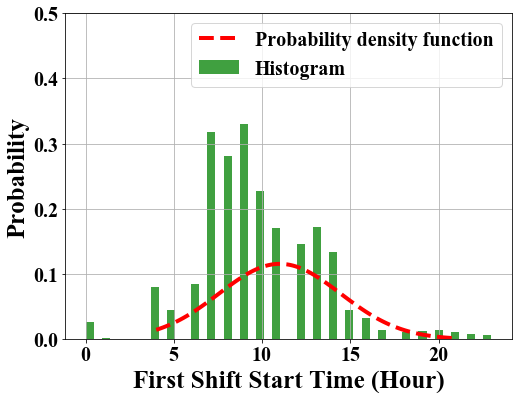

In [8]:
def Starttime_Plot(Starttime,Gau_mean,Gau_std):

    x = np.linspace(Starttime.min(), Starttime.max(), 100)

    p = norm.pdf(x, Gau_mean, Gau_std)

    figsize = 8,6

    font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

    font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}



    figure, ax1 = plt.subplots(figsize=figsize)

    labels = ax1.get_xticklabels() + ax1.get_yticklabels()

    [label.set_fontsize(20) for label in labels]

    [label.set_fontname('Times New Roman') for label in labels]



    ax1.plot(x,p,'r--',linewidth=4,label='Probability density function')

    ax1.hist(Starttime2, 50,label='Histogram',facecolor='g', density=True, alpha=0.75)

    ax1.set_ylabel('Probability',font_label)

    ax1.set_xlabel('First Shift Start Time (Hour)',font_label)

    ax1.legend(loc = 'upper right',prop=font_legend)
    
    ax1.set_ylim([0,0.5])

    plt.grid()

    plt.show()

Starttime_Plot(Starttime3,Gau_mean_3,Gau_std_3)

# Shift GAP

In [9]:
'''Shift Gap: Gamma'''

shiftGap1 = Cluster1[:,7]
shiftGap2 = Cluster2[:,7]
shiftGap3 = Cluster3[:,7]

'''Gap Value'''

Gap1=np.array([x for x in shiftGap1 if x !=0])

Gap2=np.array([x for x in shiftGap2 if x !=0])

Gap3=np.array([x for x in shiftGap3 if x !=0])

gam_shape1, gam_loc1, gam_scale1 = gamma.fit(Gap1)

gam_shape2, gam_loc2, gam_scale2 = gamma.fit(Gap2)

gam_shape3, gam_loc3, gam_scale3 = gamma.fit(Gap3)

def Generate_GAP(arr1,arr2,shape, scale,num):
    
    for i in range(num):
    
        s=np.random.gamma(shape, scale)

        while s<arr2.min() or s>arr2.max():

             s=np.random.gamma(shape, scale)
                
        arr1.append(s)
        
    return np.array(arr1)

Generated_shiftGap1=list()

Generated_shiftGap2=list()

Generated_shiftGap3=list()

    
Generated_shiftGap1=Generate_Dur(Generated_shiftGap1,shiftGap1,gam_shape1, gam_scale1,count1)

Generated_shiftGap2=Generate_Dur(Generated_shiftGap2,shiftGap2,gam_shape2, gam_scale2,count2)  

Generated_shiftGap3=Generate_Dur(Generated_shiftGap3,shiftGap3,gam_shape3, gam_scale3,count3)


print(gam_shape1, gam_scale1)

print(gam_shape2, gam_scale2)

print(gam_shape3, gam_scale3)


0.873808678779447 2.3847857568958455
1.0688701356839792 3.04666737178355
0.9692727541436149 2.885784082909895


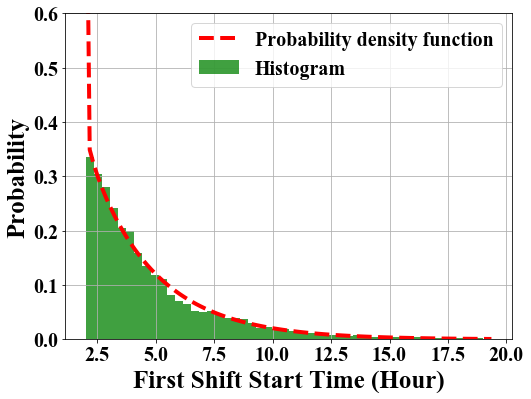

In [10]:
def ShiftGap_Plot(shiftGap,gam_shape,gam_loc,gam_scale):

    x = np.linspace(shiftGap.min(), shiftGap.max(), 100)
    
    pdf_gamma = gamma.pdf(x, gam_shape,gam_loc,gam_scale)

    figsize = 8,6

    font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

    font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}

    figure, ax1 = plt.subplots(figsize=figsize)

    labels = ax1.get_xticklabels() + ax1.get_yticklabels()

    [label.set_fontsize(20) for label in labels]

    [label.set_fontname('Times New Roman') for label in labels]

    ax1.plot(x,pdf_gamma,'r--',linewidth=4,label='Probability density function')

    ax1.hist(shiftGap, 50,label='Histogram',facecolor='g', density=True, alpha=0.75)

    ax1.set_ylabel('Probability',font_label)

    ax1.set_xlabel('First Shift Start Time (Hour)',font_label)

    ax1.legend(loc = 'upper right',prop=font_legend)
    
    ax1.set_ylim([0,0.6])

    plt.grid()

    plt.show()

ShiftGap_Plot(Gap3,gam_shape3,gam_loc3,gam_scale3)

# Resample


First Shift Start Hour + Avg. Shift Durattion * Shift Quantity + Avg. Shift Gap * ( Shift Quantity -1)


In [11]:
'''Resample'''

for i in range(max(count1,count2,count3)):
    
    if i < count1:
        
        while Generated_Start1[i] + Generated_shiftDur1[i]*shiftNum1[i] + Generated_shiftGap1[i]*(shiftNum1[i]-1) > 28:
            
            dur=np.random.weibull(wbl_loc1)*wbl_scale1
            
            start=np.random.normal(Gau_mean_1,Gau_std_1)
            
            gap=np.random.gamma(gam_shape1, gam_scale1)
            
            while dur<shiftDur1.min() or dur>shiftDur1.max() or start<Starttime1.min() or start>Starttime1.max() or gap<shiftGap1.min() or gap>shiftGap1.max():
                
                dur=np.random.weibull(wbl_loc1)*wbl_scale1
            
                start=np.random.normal(Gau_mean_1,Gau_std_1)

                gap=np.random.gamma(gam_shape1, gam_scale1)
            
                Generated_shiftDur1[i]=dur

                Generated_Start1[i]=start

                Generated_shiftGap1[i]=gap

    if i < count2:
        
        while Generated_Start2[i] + Generated_shiftDur2[i]*shiftNum2[i] + Generated_shiftGap2[i]*(shiftNum2[i]-1) > 28:

                dur=np.random.weibull(wbl_loc2)*wbl_scale2

                start=np.random.normal(Gau_mean_2,Gau_std_2)

                gap=np.random.gamma(gam_shape2, gam_scale2)

                while dur<shiftDur2.min() or dur>shiftDur2.max() or start<Starttime2.min() or start>Starttime2.max() or gap<shiftGap2.min() or gap>shiftGap2.max():

                    dur=np.random.weibull(wbl_loc2)*wbl_scale2

                    start=np.random.normal(Gau_mean_2,Gau_std_2)

                    gap=np.random.gamma(gam_shape2, gam_scale2)

                    Generated_shiftDur2[i]=dur

                    Generated_Start2[i]=start

                    Generated_shiftGap2[i]=gap

    if i < count3:
        
        while Generated_Start3[i] + Generated_shiftDur3[i]*shiftNum3[i] + Generated_shiftGap3[i]*(shiftNum3[i]-1) > 28:

                dur=np.random.weibull(wbl_loc3)*wbl_scale3

                start=np.random.normal(Gau_mean_3,Gau_std_3)

                gap=np.random.gamma(gam_shape3, gam_scale3)

                while dur<shiftDur3.min() or dur>shiftDur3.max() or start<Starttime3.min() or start>Starttime3.max() or gap<shiftGap3.min() or gap>shiftGap3.max():

                    dur=np.random.weibull(wbl_loc3)*wbl_scale3

                    start=np.random.normal(Gau_mean_3,Gau_std_3)

                    gap=np.random.gamma(gam_shape3, gam_scale3)

                    Generated_shiftDur3[i]=dur

                    Generated_Start3[i]=start

                    Generated_shiftGap3[i]=gap

            


# Shift  Details

In [18]:
'''Start and End time of drivers'''

Generated_shiftStartTime = list()

Generated_shiftEndTime = list()

Cluster_id=list()

Driver_id=list()

Shift_id=list()

k=0


for i in range(count1):
    
    Start=Generated_Start1[i]
    Shift_Num=int(shiftNum1[i])
    Shift_Dur=Generated_shiftDur1[i]
    Shift_Gap=Generated_shiftGap1[i]
    
    driver_id='D_'+str(k)
    
    k+=1 
    
    for j in range(Shift_Num):
        
        shift_id='S_'+str(j)
        
        start=Start+j*Shift_Dur+j*Shift_Gap
        
        end=start+Shift_Dur
        
        Generated_shiftStartTime.append(start)
        
        Generated_shiftEndTime.append(end)
        
        Cluster_id.append('Cluster1')
        
        Driver_id.append(driver_id)
        
        Shift_id.append(shift_id)
        
        
        
        
    
        
        
for i in range(count2):
    
    Start=Generated_Start2[i]
    Shift_Num=int(shiftNum2[i])
    Shift_Dur=Generated_shiftDur2[i]
    Shift_Gap=Generated_shiftGap2[i]
    
    driver_id='D_'+str(k)
    
    k+=1
    
    
    for j in range(Shift_Num):
        
        shift_id='S_'+str(j)
        
        start=Start+j*Shift_Dur+j*Shift_Gap
        
        end=start+Shift_Dur
        
        Generated_shiftStartTime.append(start)
        
        Generated_shiftEndTime.append(end)
        
        Cluster_id.append('Cluster2')
        
        Driver_id.append(driver_id)
        
        Shift_id.append(shift_id)
        
for i in range(count3):
    
    Start=Generated_Start3[i]
    Shift_Num=int(shiftNum3[i])
    Shift_Dur=Generated_shiftDur3[i]
    Shift_Gap=Generated_shiftGap3[i]
    
    driver_id='D_'+str(k)
    
    k+=1
    
    
    for j in range(Shift_Num):
        
        shift_id='S_'+str(j)
        
        start=Start+j*Shift_Dur+j*Shift_Gap
        
        end=start+Shift_Dur
        
        Generated_shiftStartTime.append(start)
        
        Generated_shiftEndTime.append(end)
        
        Cluster_id.append('Cluster3')
        
        Driver_id.append(driver_id)
        
        Shift_id.append(shift_id)
        
Generate_df=pd.DataFrame(Generated_shiftStartTime,columns=['Shift Start time (Hour)'])

Generate_df['Driver_id']=Driver_id

Generate_df['Cluster_id']=Cluster_id

Generate_df['Shift_id']=Shift_id

Generate_df['Shift End time (Hour)']=Generated_shiftEndTime

Generate_df=Generate_df[['Driver_id','Shift_id','Shift Start time (Hour)','Shift End time (Hour)','Cluster_id']]

Generate_df=Generate_df.sort_values(by='Shift Start time (Hour)')

Generate_df['Duration']=Generate_df.apply(lambda x:x['Shift End time (Hour)']-x['Shift Start time (Hour)'],axis=1)

Generate_df['Shift Start time (Hour)']=Generate_df.apply(lambda x:round(x['Shift Start time (Hour)'],2),axis=1)

Generate_df['Shift End time (Hour)']=Generate_df.apply(lambda x:round(x['Shift End time (Hour)'],2),axis=1)

Generate_df=Generate_df.reset_index(drop=True)

Generate_df['Active_range']=Generate_df.apply(lambda x:[round(y,2) for y in np.arange(x['Shift Start time (Hour)'],x['Shift End time (Hour)']+0.01,0.01)],axis=1)

Generate_df



,Driver_id,Shift_id,Shift Start time (Hour),Shift End time (Hour),Cluster_id,Duration,Active_range
0,D_2126,S_0,0.02,2.68,Cluster1,2.663306,"[0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.0..."
1,D_4910,S_0,0.02,0.41,Cluster1,0.388095,"[0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.0..."
2,D_1905,S_0,0.02,0.52,Cluster1,0.494261,"[0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.0..."
3,D_24574,S_0,0.03,2.41,Cluster2,2.380091,"[0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1..."
4,D_7260,S_0,0.03,0.67,Cluster1,0.640309,"[0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1..."
5,D_3440,S_0,0.03,0.59,Cluster1,0.559607,"[0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1..."
6,D_1652,S_0,0.04,3.17,Cluster1,3.132777,"[0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11..."
7,D_6569,S_0,0.04,2.50,Cluster1,2.460888,"[0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11..."
8,D_12431,S_0,0.04,0.21,Cluster1,0.170236,"[0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11..."
9,D_16789,S_0,0.05,0.10,Cluster2,0.052415,"[0.05, 0.06, 0.07, 0.08, 0.09, 0.1]"


In [24]:
'''Statitics'''

def explode(df, col):
    df[col] = df[col].apply(lambda x: [x] if not isinstance(x, list) else x)
    return df.drop(col, axis=1).join(
        pd.DataFrame(list(df[col])).stack().reset_index(level=1, drop=True).rename(col)
    )   


Stat_df=explode(Generate_df,'Active_range')

Stat_df=Stat_df.rename(columns={'Active_range':'step'})

Stat_df=Stat_df.groupby('step').count()

Stat_df['step']=Stat_df.index

Stat_df=Stat_df.rename(columns={'Driver_id':'Count'})

Stat_df=Stat_df[['step','Count']]

Stat_df=Stat_df.reset_index(drop=True)

Stat_df=Stat_df.sort_values(by='step')

Stat_df=Stat_df.reset_index(drop=True)

Stat_df

,step,Count
0,0.02,3
1,0.03,6
2,0.04,9
3,0.05,12
4,0.06,19
5,0.07,21
6,0.08,24
7,0.09,25
8,0.10,29
9,0.11,32


In [43]:
Validate_df= pd.read_excel('./Data/Source/shiftDataNov15.xlsx')

Validate_df=Validate_df[['Driver ID','Shift Start Time','Shift End Time']]

'''To timestamp'''
def stamp_transit(time_str):
    timeArray = time.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    timeStamp = int(time.mktime(timeArray))
    return timeStamp
    
'''To time step'''
def stamp_to_step(timestamp,date_str,step):
    baseline = date_str +" 00:00:00";
    baseline = int(stamp_transit(baseline))
    current_step=round((timestamp-baseline)/step,2)
    return current_step



date_str='2016-11-15'

Validate_df['Shift Start time (Hour)']=Validate_df.apply(lambda x:stamp_to_step(x['Shift Start Time'],date_str,3600.00),axis=1)

Validate_df['Shift End time (Hour)']=Validate_df.apply(lambda x:stamp_to_step(x['Shift End Time'],date_str,3600.00),axis=1)

Validate_df=Validate_df[['Driver ID','Shift Start time (Hour)','Shift End time (Hour)']]

Validate_df['Active_range']=Validate_df.apply(lambda x:[round(y,2) for y in np.arange(x['Shift Start time (Hour)'],x['Shift End time (Hour)']+0.01,0.01)],axis=1)


Validate_Stat=explode(Validate_df,'Active_range')

Validate_Stat=Validate_Stat.rename(columns={'Active_range':'step'})

Validate_Stat=Validate_Stat.groupby('step').count()

Validate_Stat['step']=Validate_Stat.index

Validate_Stat=Validate_Stat.rename(columns={'Driver ID':'Count'})

Validate_Stat=Validate_Stat[['step','Count']]

Validate_Stat=Validate_Stat.reset_index(drop=True)

Validate_Stat=Validate_Stat.sort_values(by='step')

Validate_Stat=Validate_Stat.reset_index(drop=True)

Validate_Stat



,step,Count
0,4.00,4
1,4.01,16
2,4.02,26
3,4.03,40
4,4.04,47
5,4.05,54
6,4.06,63
7,4.07,73
8,4.08,78
9,4.09,88


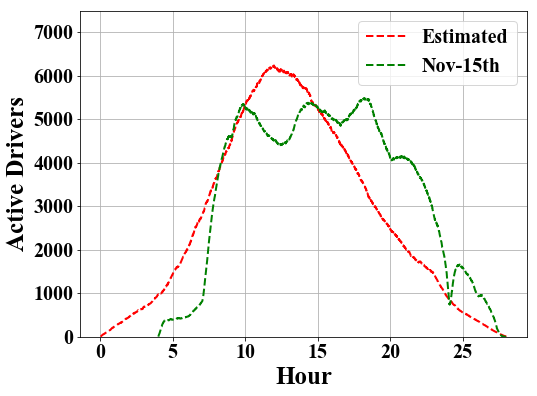

In [47]:
figsize = 8,6

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(figsize=figsize)

labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]

ax1.plot(Stat_df['step'],Stat_df['Count'],'r--',linewidth=2,label='Estimated')

ax1.plot(Validate_Stat['step'],Validate_Stat['Count'],'g--',linewidth=2,label='Nov-15th')

ax1.set_ylabel('Active Drivers',font_label)

ax1.set_xlabel('Hour',font_label)

ax1.legend(loc = 'upper right',prop=font_legend)


ax1.set_ylim([0,7500])


plt.grid()

plt.show()